In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
DATA_DIR = '../pickles'

In [3]:
df = pd.read_pickle(os.path.join(DATA_DIR, 'station1_normalized.pkl'))
df.head(10)

,date,ref,NO2_61FD,NO2_61F0,NO2_61EF,rh,t_grad,pressure,temp,pluvio
0,2017-09-28 10:15:00,38.5,-0.324687,-0.487027,0.433465,0.167023,-1.039505,0.375594,0.898638,0.0
1,2017-09-28 10:30:00,32.3,-0.343192,-0.325877,-0.412283,0.083982,-1.094050,0.375594,0.946776,0.0
2,2017-09-28 10:45:00,38.5,-0.010107,-0.161505,-0.198236,0.065528,-0.984961,0.375594,0.970844,0.0
3,2017-09-28 11:00:00,29.7,-0.386370,-0.554710,-0.339194,-0.063647,-0.984961,0.356064,1.091187,0.0
4,2017-09-28 11:15:00,19.4,-0.386370,-0.422567,-0.412283,-0.146688,-1.203138,0.375594,1.163393,0.0
5,2017-09-28 11:30:00,10.8,-0.386370,-0.619170,-0.412283,-0.238957,-1.039505,0.375594,1.259668,0.0
6,2017-09-28 11:45:00,12.4,-0.386370,-0.586940,-0.412283,-0.358905,-1.203138,0.375594,1.283736,0.0
7,2017-09-28 12:00:00,12.3,-0.386370,-0.619170,-0.412283,-0.405039,-1.148594,0.375594,1.307805,0.0
8,2017-09-28 12:15:00,9.7,-0.386370,-0.619170,-0.412283,-0.423493,-1.312227,0.356064,1.355942,0.0
9,2017-09-28 12:30:00,13.8,-0.386370,-0.619170,-0.412283,-0.552668,-1.475859,0.356064,1.548491,0.0


In [4]:
def from_dataframe_to_xy(df):
    return (np.array(df[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh', 't_grad', 'pressure', 'pluvio']]),
            np.array(df['ref']))

def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy_look_back(df, look_back):
    X, y = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X.append(np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 't_grad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8))
        y.append(np.array(df.iloc[i]['ref']))
        i += 1
        if i == len(df):
            break
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[3]))
    return X, y

In [5]:
def gru(nb_units, input_shape, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_shape, activation='tanh', return_sequences=True))#, recurrent_dropout=1))
    model.add(GRU(nb_units, activation='tanh'))#, recurrent_dropout=1))
    model.add(Dense(nb_units, activation='relu'))
    
    opti = Adam(lr=0.0003)
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    model.compile(loss=loss, optimizer=opti)
    
    return model

In [6]:
df_train, df_test = split_dataframe(df, 0.5)
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy_look_back(df_train, 96)
X_valid, y_valid = dataframe_to_xy_look_back(df_valid, 96)
X_test, y_test = dataframe_to_xy_look_back(df_test, 96)


In [7]:
model = gru(32, X_train.shape[1:])
early_stopping = EarlyStopping(patience=10)
history = model.fit(X_train, y_train, \
                    batch_size=1, \
                    epochs=1000, \
                    validation_data=(X_valid, y_valid), \
                    callbacks=[early_stopping])

Train on 1110 samples, validate on 507 samples
Epoch 1/1000
1110/1110 [==============================] - 101s 91ms/step - loss: 1950.7720 - val_loss: 861.2698
Epoch 2/1000
1110/1110 [==============================] - 99s 90ms/step - loss: 549.3819 - val_loss: 820.2355
Epoch 3/1000
1110/1110 [==============================] - 101s 91ms/step - loss: 263.8679 - val_loss: 624.1449
Epoch 4/1000
1110/1110 [==============================] - 103s 92ms/step - loss: 207.9696 - val_loss: 491.2123
Epoch 5/1000
1110/1110 [==============================] - 100s 90ms/step - loss: 185.2078 - val_loss: 550.9860
Epoch 6/1000
1110/1110 [==============================] - 95s 86ms/step - loss: 175.7325 - val_loss: 458.9797
Epoch 7/1000
1110/1110 [==============================] - 89s 80ms/step - loss: 171.2484 - val_loss: 464.5203
Epoch 8/1000
1110/1110 [==============================] - 85s 77ms/step - loss: 164.1885 - val_loss: 362.8118
Epoch 9/1000
1110/1110 [==============================] - 79s 71ms/s

In [8]:
model.evaluate(X_test, y_test, verbose=0)

301.14895077202266

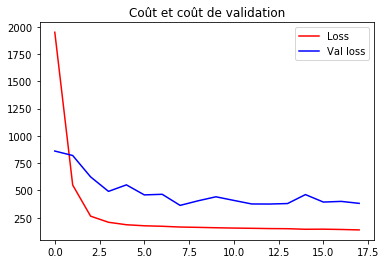

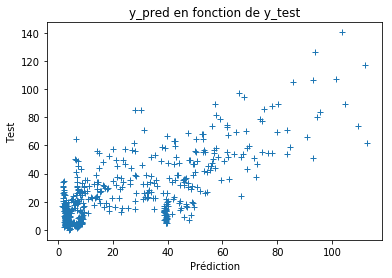

In [9]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [10]:
def gru_plus_dense(nb_units, input_shape, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_shape, activation='relu')) 
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))
    opti = Adam(lr=0.0003)
    model.compile(loss=loss, optimizer=opti)
    
    return model

In [11]:
model = gru_plus_dense(32, X_train.shape[1:])
history = model.fit(X_train, y_train, \
                    batch_size=1, \
                    epochs=1000, \
                    validation_data=(X_valid, y_valid), \
                    callbacks=[early_stopping])

Train on 1110 samples, validate on 507 samples
Epoch 1/1000
1110/1110 [==============================] - 36s 32ms/step - loss: 1447.0563 - val_loss: 822.5669
Epoch 2/1000
1110/1110 [==============================] - 39s 35ms/step - loss: 555.4151 - val_loss: 632.1768
Epoch 3/1000
1110/1110 [==============================] - 34s 31ms/step - loss: 477.6736 - val_loss: 602.9837
Epoch 4/1000
1110/1110 [==============================] - 33s 30ms/step - loss: 401.1617 - val_loss: 561.0624
Epoch 5/1000
1110/1110 [==============================] - 33s 30ms/step - loss: 368.4187 - val_loss: 554.0670
Epoch 6/1000
1110/1110 [==============================] - 34s 31ms/step - loss: 341.6406 - val_loss: 526.2370
Epoch 7/1000
1110/1110 [==============================] - 30s 27ms/step - loss: 303.6367 - val_loss: 494.4000
Epoch 8/1000
1110/1110 [==============================] - 32s 29ms/step - loss: 272.6277 - val_loss: 495.4343
Epoch 9/1000
1110/1110 [==============================] - 29s 27ms/step 

In [12]:
model.evaluate(X_test, y_test, verbose=0)

549.80215309924029

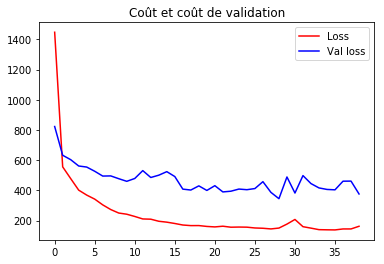

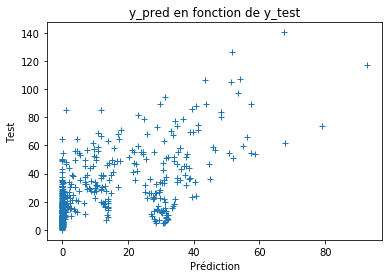

In [13]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [14]:
len(df_test)

604